# London Crime

In this notebook I will explore the past decade of all recorded crime in London, I will look for any trends in crime and vizualise the most at risk London boroughs by crime type.

The data for this exploration can be found on the opensource London Datastore: https://data.london.gov.uk/dataset/mps-monthly-crime-dahboard-data

## Imports

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

## Load Data

In [2]:
df_offs = pd.read_csv('data/Monthly Crime New Cats Borough Level Offs Type.csv')
df_SDs = pd.read_csv('data/Monthly Crime New Cats Borough Level SDs Type.csv')

## Initial Exploration

We have two datasets that hold information relating to all recorded offenses and sanction detections within each borough of London dating from 2012 to the present day.

Sanction detections can be defined as offenses that have been brought to justice, they are defined as 'offences that are cleared up through a formal sanction to the offender'.

Both datasets contain statistics related to various categories and sub-categories of crime.

We can begin to analyze trending rates of various crimes in each borough of London, we can also look into trends relating to the proportion of detected crimes.

In [3]:
df_offs.isna().sum().sum(), df_SDs.isna().sum().sum()

(0, 0)

We have no null values in either dataset

In [4]:
df_offs.shape, df_SDs.shape

((1848, 131), (1848, 131))

Both datasets are of the same shape

In [5]:
df_offs.head(2)

Borough                             MajorText  \
0  Aviation Security(SO18)  Miscellaneous Crimes Against Society   
1     Barking and Dagenham  Miscellaneous Crimes Against Society   

                        MinorText  201201  201202  201203  201204  201205  \
0  Absconding from Lawful Custody       0       0       0       0       0   
1  Absconding from Lawful Custody       0       0       0       0       0   

   201206  201207  ...  202111  202112  202201  202202  202203  202204  \
0       0       0  ...       0       0       0       0       0       0   
1       0       0  ...       0       0       0       0       0       0   

   202205  202206  202207  202208  
0       0       0       0       0  
1       0       0       0       0  

[2 rows x 131 columns]

In [6]:
df_SDs.head(2)

Borough                             MajorText  \
0  Aviation Security(SO18)  Miscellaneous Crimes Against Society   
1     Barking and Dagenham  Miscellaneous Crimes Against Society   

                        MinorText  201201  201202  201203  201204  201205  \
0  Absconding from Lawful Custody       0       0       0       0       0   
1  Absconding from Lawful Custody       0       0       0       0       0   

   201206  201207  ...  202111  202112  202201  202202  202203  202204  \
0       0       0  ...       0       0       0       0       0       0   
1       0       0  ...       0       0       0       0       0       0   

   202205  202206  202207  202208  
0       0       0       0       0  
1       0       0       0       0  

[2 rows x 131 columns]

In [7]:
# Confirmation that both datasets have identical data structures

(df_SDs.columns == df_offs.columns).all() & (df_SDs.index == df_offs.index).all() 

True

I am going to start by pivoting and transposing these tables to make the data simpler to access and understand at each level (borough, crime & sub-crime). Dates will be indexed as datetime objects for time-series analysis

In [8]:
df_SDs_pivot = df_SDs.pivot_table(index=['Borough','MajorText','MinorText'])
df_offs_pivot = df_offs.pivot_table(index=['Borough','MajorText','MinorText'])

df_SDs_pivot_transpose = df_SDs_pivot.T
df_offs_pivot_transpose = df_offs_pivot.T
df_SDs_pivot_transpose.index = pd.to_datetime(df_SDs_pivot_transpose.index, format='%Y%m')#.to_period('m')
df_offs_pivot_transpose.index = pd.to_datetime(df_offs_pivot_transpose.index, format='%Y%m')#.to_period('m')

In [9]:
df_offs_pivot_transpose.head(2)

Borough      Aviation Security(SO18)                  \
MajorText  Arson and Criminal Damage                   
MinorText                      Arson Criminal Damage   
2012-01-01                         0               4   
2012-02-01                         0               6   

Borough                                                              \
MajorText                           Burglary                          
MinorText  Burglary - Business and Community Burglary - Residential   
2012-01-01                                 0                      0   
2012-02-01                                 0                      0   

Borough                                                                        \
MajorText     Drug Offences                      Historical Fraud and Forgery   
MinorText  Drug Trafficking Possession of  Drugs Historical Fraud and Forgery   
2012-01-01                0                   12                           18   
2012-02-01                1                   10                           12   

Borough                                                                       \
MajorText  Miscellaneous Crimes Against Society                                
MinorText        Absconding from Lawful Custody Aiding Suicide Bail Offences   
2012-01-01                                    0              0             0   
2012-02-01                                    0              0             0   

Borough     ... Westminster                                \
MajorText   ...       Theft                                 
MinorText   ... Other Theft Shoplifting Theft from Person   
2012-01-01  ...        1843         337               842   
2012-02-01  ...        1578         335               672   

Borough                                                                \
MajorText           Vehicle Offences                                    
MinorText  Aggravated Vehicle Taking Interfering with a Motor Vehicle   
2012-01-01                         0                                8   
2012-02-01                         0                                4   

Borough                                                                   \
MajorText                                                                  
MinorText  Theft from a Motor Vehicle Theft or Taking of a Motor Vehicle   
2012-01-01                        176                                 52   
2012-02-01                        129                                 19   

Borough                                                      \
MajorText  Violence Against the Person                        
MinorText                     Homicide Violence with Injury   
2012-01-01                           0                  271   
2012-02-01                           0                  211   

Borough                             
MajorText                           
MinorText  Violence without Injury  
2012-01-01                     271  
2012-02-01                     287  

[2 rows x 1848 columns]

Now, lets begin to look at our boroughs and the different categories of crimes recorded

In [31]:
df_sub_cat_total = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum())
df_sub_cat_total.columns = ['cat_total']
df_sub_cat_total

df_test = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum())
df_test.columns = ['Count']
df_test
cat_sorted = df_test.groupby('MajorText').sum().sort_values(by='Count', ascending=False).reset_index()

In [32]:
df_sub_cat_total

cat_total
MajorText                            MinorText                                                    
Arson and Criminal Damage            Arson                                                   21153
                                     Criminal Damage                                        593374
Burglary                             Burglary - Business and Community                      243125
                                     Burglary - Residential                                 540729
Drug Offences                        Drug Trafficking                                        44726
                                     Possession of  Drugs                                   444418
Historical Fraud and Forgery         Historical Fraud and Forgery                            33164
Miscellaneous Crimes Against Society Absconding from Lawful Custody                            334
                                     Aiding Suicide                                              4
                                     Bail Offences                                             735
                                     Bigamy                                                    151
                                     Concealing an Infant Death Close to Birth                   3
                                     Dangerous Driving                                        4182
                                     Disclosure, Obstruction, False or Misleading St...        732
                                     Exploitation of Prostitution                              302
                                     Forgery or Use of Drug Prescription                       570
                                     Fraud or Forgery Associated with Driver Records           713
                                     Going Equipped for Stealing                              5739
                                     Handling Stolen Goods                                   10778
                                     Making, Supplying or Possessing Articles for us...       8567
                                     Obscene Publications                                    19704
                                     Offender Management Act                                  1933
                                     Other Forgery                                            6214
                                     Other Notifiable Offences                               15238
                                     Perjury                                                   188
                                     Perverting Course of Justice                             7943
                                     Possession of False Documents                            3879
                                     Profitting From or Concealing Proceeds of Crime          4812
                                     Soliciting for Prostitution                               888
                                     Threat or Possession With Intent to Commit Crim...      19931
                                     Wildlife Crime                                            118
Possession of Weapons                Other Firearm Offences                                    767
                                     Other Knife Offences                                        8
                                     Possession of  Firearm with Intent                       3000
                                     Possession of  Firearms Offences                         6987
                                     Possession of  Other Weapon                             25408
                                     Possession of Article with Blade or Point               27122
Public Order Offences                Other Offences Against the State, or Public Order       67281
                                     Public Fear Alarm or Distress                          323090
                              

In [25]:
cat_sorted.to_numpy()

array([['Theft', 2283632],
       ['Violence Against the Person', 2032429],
       ['Vehicle Offences', 1068178],
       ['Burglary', 783854],
       ['Arson and Criminal Damage', 614527],
       ['Drug Offences', 489144],
       ['Public Order Offences', 483008],
       ['Robbery', 306318],
       ['Sexual Offences', 187791],
       ['Miscellaneous Crimes Against Society', 113658],
       ['Possession of Weapons', 63292],
       ['Historical Fraud and Forgery', 33164]], dtype=object)

In [33]:
df_sorted = pd.DataFrame()

for cat, total in cat_sorted:
    
    df_temp = df_sub_cat_total.loc[cat].sort_values(by='cat_total', ascending=False).reset_index()
    df_temp['cat'] = cat
    df_temp['total'] = total
    df_temp.set_index(['cat','total','MinorText','cat_total'],inplace=True)
    df_sorted = pd.concat([df_sorted, df_temp])
    
df_sorted =  df_sorted.reset_index()

ValueError: too many values to unpack (expected 2)

In [622]:
style_ = df_sorted.style

In [623]:
df_border_h = df_sorted.copy()
df_border_v = df_sorted.copy()

In [624]:
idx = pd.IndexSlice

for index, val in enumerate(df_sorted.groupby('cat', sort=False).groups.values()):
    
    slice_ = idx[idx[val[0]:val[-1]]]
    
    df_border_h.iloc[val[0]] = 'border-top'
    df_border_h.iloc[val[-1]] = 'border-bottom'
    
    if index % 2 == 0:
        style_.set_properties(**{'background-color': '#ecf3fd'}, subset=slice_)
        
    else:
        style_.set_properties(**{'background-color': '#ffffff'}, subset=slice_)
        
df_border_v[df_border_v.columns] = 'border-right'


In [619]:
df_sorted['cat'] = df_sorted['cat'].mask(df_sorted['cat'].duplicated(), '')
df_sorted['total'] = df_sorted['total'].mask(df_sorted['total'].duplicated(), '')

In [626]:
style_.set_table_styles([
    {'selector': '', 'props': [('border', '2px solid black !important')]},
    {'selector': '.border-top', 'props': 'border-top: 2px solid black !important'},
    {'selector': '.border-right', 'props': 'border-right: 2px solid black !important'}
                         ], overwrite=False)
style_.hide_index()
style_.set_caption('Total Number of Crimes by Category')
#style_.format({'total': '{:,.0f}', 'cat_total': '{:,.0f}'})
style_.set_td_classes(df_border_h)# + df_border_v)

In [603]:
style_

ValueError: Unknown format code 'f' for object of type 'str'

In [12]:
df_offs_pivot_transpose.groupby(axis=1, level=(2)).sum().sum().sort_values(ascending=False)

MinorText
Violence without Injury                                              1273195
Other Theft                                                          1189754
Violence with Injury                                                  757919
Theft from a Motor Vehicle                                            664470
Criminal Damage                                                       593374
Burglary - Residential                                                540729
Theft from Person                                                     446904
Possession of  Drugs                                                  444418
Shoplifting                                                           435157
Public Fear Alarm or Distress                                         323090
Robbery of Personal Property                                          283598
Theft or Taking of a Motor Vehicle                                    274977
Burglary - Business and Community                                 

In [415]:
df_sorted['cat'] = df_sorted['cat'].mask(df_sorted['cat'].duplicated(), '')
df_sorted['total'] = df_sorted['total'].mask(df_sorted['total'].duplicated(), '')

In [436]:
df_sorted.dtypes

cat          object
total         int64
MinorText    object
cat_total     int64
dtype: object

In [355]:
df_sorted.style = style_

AttributeError: can't set attribute

In [298]:
for i in (0,5):
    style_.set_properties(**{'background-color': '#ecf3fd'}, subset=idx[idx[0:3]]) \
            #    .set_properties(**{'background-color': '#ffffff'}, subset=idx[idx[4:6]]) \
            #    .set_properties(**{'background-color': '#ffffff'}, subset=idx[idx[4:6]]) \
            #    .set_properties(**{'background-color': '#ffffff'}, subset=idx[idx[4:6]]) \
            #    .set_properties(**{'background-color': '#ffffff'}, subset=idx[idx[4:6]]) \
            #    .set_properties(**{'background-color': '#ffffff'}, subset=idx[idx[4:6]]) \ 

In [300]:
style_

In [255]:
idx = pd.IndexSlice

for value in df_sorted.groupby('cat').groups.values():
    df_sorted = df_sorted.style.set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

AttributeError: 'Styler' object has no attribute 'style'

In [256]:
df_sorted

In [208]:
df_sorted.style.set_properties(subset=slice_, **{'border': '1px black solid !important'})

RangeIndex(start=0, stop=56, step=1)

In [124]:
df_sub_cat_total = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum())
df_sub_cat_total.columns = ['cat_total']
df_sub_cat_total

cat_total
MajorText                            MinorText                                                    
Arson and Criminal Damage            Arson                                                   21153
                                     Criminal Damage                                        593374
Burglary                             Burglary - Business and Community                      243125
                                     Burglary - Residential                                 540729
Drug Offences                        Drug Trafficking                                        44726
                                     Possession of  Drugs                                   444418
Historical Fraud and Forgery         Historical Fraud and Forgery                            33164
Miscellaneous Crimes Against Society Absconding from Lawful Custody                            334
                                     Aiding Suicide                                              4
                                     Bail Offences                                             735
                                     Bigamy                                                    151
                                     Concealing an Infant Death Close to Birth                   3
                                     Dangerous Driving                                        4182
                                     Disclosure, Obstruction, False or Misleading St...        732
                                     Exploitation of Prostitution                              302
                                     Forgery or Use of Drug Prescription                       570
                                     Fraud or Forgery Associated with Driver Records           713
                                     Going Equipped for Stealing                              5739
                                     Handling Stolen Goods                                   10778
                                     Making, Supplying or Possessing Articles for us...       8567
                                     Obscene Publications                                    19704
                                     Offender Management Act                                  1933
                                     Other Forgery                                            6214
                                     Other Notifiable Offences                               15238
                                     Perjury                                                   188
                                     Perverting Course of Justice                             7943
                                     Possession of False Documents                            3879
                                     Profitting From or Concealing Proceeds of Crime          4812
                                     Soliciting for Prostitution                               888
                                     Threat or Possession With Intent to Commit Crim...      19931
                                     Wildlife Crime                                            118
Possession of Weapons                Other Firearm Offences                                    767
                                     Other Knife Offences                                        8
                                     Possession of  Firearm with Intent                       3000
                                     Possession of  Firearms Offences                         6987
                                     Possession of  Other Weapon                             25408
                                     Possession of Article with Blade or Point               27122
Public Order Offences                Other Offences Against the State, or Public Order       67281
                                     Public Fear Alarm or Distress                          323090
                              

In [44]:
df_sub_cat_total = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(2)).sum().sum())
df_sub_cat_total.columns = ['cat_total']
df_sub_cat_total

df_test = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum())
df_test.columns = ['Count']
df_test
df_sorted = df_test.groupby('MajorText').sum().sort_values(by='MajorText', ascending=False)

cat_total
MinorText                                                    
Absconding from Lawful Custody                            334
Aggravated Vehicle Taking                                9164
Aiding Suicide                                              4
Arson                                                   21153
Bail Offences                                             735
Bicycle Theft                                          211817
Bigamy                                                    151
Burglary - Business and Community                      243125
Burglary - Residential                                 540729
Concealing an Infant Death Close to Birth                   3
Criminal Damage                                        593374
Dangerous Driving                                        4182
Disclosure, Obstruction, False or Misleading St...        732
Drug Trafficking                                        44726
Exploitation of Prostitution                              302
Forgery or Use of Drug Prescription                       570
Fraud or Forgery Associated with Driver Records           713
Going Equipped for Stealing                              5739
Handling Stolen Goods                                   10778
Historical Fraud and Forgery                            33164
Homicide                                                 1315
Interfering with a Motor Vehicle                       119567
Making, Supplying or Possessing Articles for us...       8567
Obscene Publications                                    19704
Offender Management Act                                  1933
Other Firearm Offences                                    767
Other Forgery                                            6214
Other Knife Offences                                        8
Other Notifiable Offences                               15238
Other Offences Against the State, or Public Order       67281
Other Sexual Offences                                  117426
Other Theft                                           1189754
Perjury                                                   188
Perverting Course of Justice                             7943
Possession of  Drugs                                   444418
Possession of  Firearm with Intent                       3000
Possession of  Firearms Offences                         6987
Possession of  Other Weapon                             25408
Possession of Article with Blade or Point               27122
Possession of False Documents                            3879
Profitting From or Concealing Proceeds of Crime          4812
Public Fear Alarm or Distress                          323090
Racially or Religiously Aggravated Public Fear,...      91897
Rape                                                    70365
Robbery of Business Property                            22720
Robbery of Personal Property                           283598
Shoplifting                                            435157
Soliciting for Prostitution                               888
Theft from Person                                      446904
Theft from a Motor Vehicle                             664470
Theft or Taking of a Motor Vehicle                     274977
Threat or Possession With Intent to Commit Crim...      19931
Violence with Injury                                   757919
Violence without Injury                               1273195
Violent Disorder                                          740
Wildlife Crime                                            118

In [41]:
df_test.merge(df_cat_total, left_index=True, right_on=['MajorText','MinorText'])

KeyError: 'MinorText'

In [31]:
df_test = pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum())
df_test.columns = ['Count']
df_test
df_sorted = df_test.groupby('MajorText').sum().sort_values(by='MajorText', ascending=False)

Count
MajorText                            MinorText                                                  
Arson and Criminal Damage            Arson                                                 21153
                                     Criminal Damage                                      593374
Burglary                             Burglary - Business and Community                    243125
                                     Burglary - Residential                               540729
Drug Offences                        Drug Trafficking                                      44726
                                     Possession of  Drugs                                 444418
Historical Fraud and Forgery         Historical Fraud and Forgery                          33164
Miscellaneous Crimes Against Society Absconding from Lawful Custody                          334
                                     Aiding Suicide                                            4
                                     Bail Offences                                           735
                                     Bigamy                                                  151
                                     Concealing an Infant Death Close to Birth                 3
                                     Dangerous Driving                                      4182
                                     Disclosure, Obstruction, False or Misleading St...      732
                                     Exploitation of Prostitution                            302
                                     Forgery or Use of Drug Prescription                     570
                                     Fraud or Forgery Associated with Driver Records         713
                                     Going Equipped for Stealing                            5739
                                     Handling Stolen Goods                                 10778
                                     Making, Supplying or Possessing Articles for us...     8567
                                     Obscene Publications                                  19704
                                     Offender Management Act                                1933
                                     Other Forgery                                          6214
                                     Other Notifiable Offences                             15238
                                     Perjury                                                 188
                                     Perverting Course of Justice                           7943
                                     Possession of False Documents                          3879
                                     Profitting From or Concealing Proceeds of Crime        4812
                                     Soliciting for Prostitution                             888
                                     Threat or Possession With Intent to Commit Crim...    19931
                                     Wildlife Crime                                          118
Possession of Weapons                Other Firearm Offences                                  767
                                     Other Knife Offences                                      8
                                     Possession of  Firearm with Intent                     3000
                                     Possession of  Firearms Offences                       6987
                                     Possession of  Other Weapon                           25408
                                     Possession of Article with Blade or Point             27122
Public Order Offences                Other Offences Against the State, or Public Order     67281
                                     Public Fear Alarm or Distress                        323090
                                     Racially or Religiously Aggravated Public Fear,...    91897
                 

In [126]:
df_test.reindex(order, level=0).

Count
MajorText                            MinorText                                                  
Miscellaneous Crimes Against Society Concealing an Infant Death Close to Birth                 3
                                     Aiding Suicide                                            4
Possession of Weapons                Other Knife Offences                                      8
Miscellaneous Crimes Against Society Wildlife Crime                                          118
                                     Bigamy                                                  151
                                     Perjury                                                 188
                                     Exploitation of Prostitution                            302
                                     Absconding from Lawful Custody                          334
                                     Forgery or Use of Drug Prescription                     570
                                     Fraud or Forgery Associated with Driver Records         713
                                     Disclosure, Obstruction, False or Misleading St...      732
                                     Bail Offences                                           735
Public Order Offences                Violent Disorder                                        740
Possession of Weapons                Other Firearm Offences                                  767
Miscellaneous Crimes Against Society Soliciting for Prostitution                             888
Violence Against the Person          Homicide                                               1315
Miscellaneous Crimes Against Society Offender Management Act                                1933
Possession of Weapons                Possession of  Firearm with Intent                     3000
Miscellaneous Crimes Against Society Possession of False Documents                          3879
                                     Dangerous Driving                                      4182
                                     Profitting From or Concealing Proceeds of Crime        4812
                                     Going Equipped for Stealing                            5739
                                     Other Forgery                                          6214
Possession of Weapons                Possession of  Firearms Offences                       6987
Miscellaneous Crimes Against Society Perverting Course of Justice                           7943
                                     Making, Supplying or Possessing Articles for us...     8567
Vehicle Offences                     Aggravated Vehicle Taking                              9164
Miscellaneous Crimes Against Society Handling Stolen Goods                                 10778
                                     Other Notifiable Offences                             15238
                                     Obscene Publications                                  19704
                                     Threat or Possession With Intent to Commit Crim...    19931
Arson and Criminal Damage            Arson                                                 21153
Robbery                              Robbery of Business Property                          22720
Possession of Weapons                Possession of  Other Weapon                           25408
                                     Possession of Article with Blade or Point             27122
Historical Fraud and Forgery         Historical Fraud and Forgery                          33164
Drug Offences                        Drug Trafficking                                      44726
Public Order Offences                Other Offences Against the State, or Public Order     67281
Sexual Offences                      Rape                                                  70365
Public Order Offences                Racially or Religiously Aggravated Public Fear,...    91897
Sexual Offences  

In [26]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

pd.DataFrame(df_offs_pivot_transpose.groupby(axis=1, level=(1,2)).sum().sum()) \
                            .sort_values(['MajorText','MinorText'],ascending=[True,False]).style.set_table_styles([])

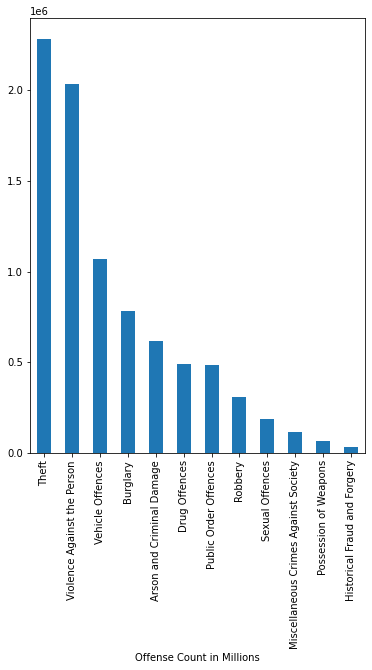

In [13]:
fix, ax = plt.subplots(figsize=(6,8))
df_offs_pivot_transpose.groupby(axis=1, level=1).sum().sum().sort_values(ascending=False).plot(kind='bar')
ax.set_ylabel('')
ax.set_xlabel('Offense Count in Millions')
plt.show();

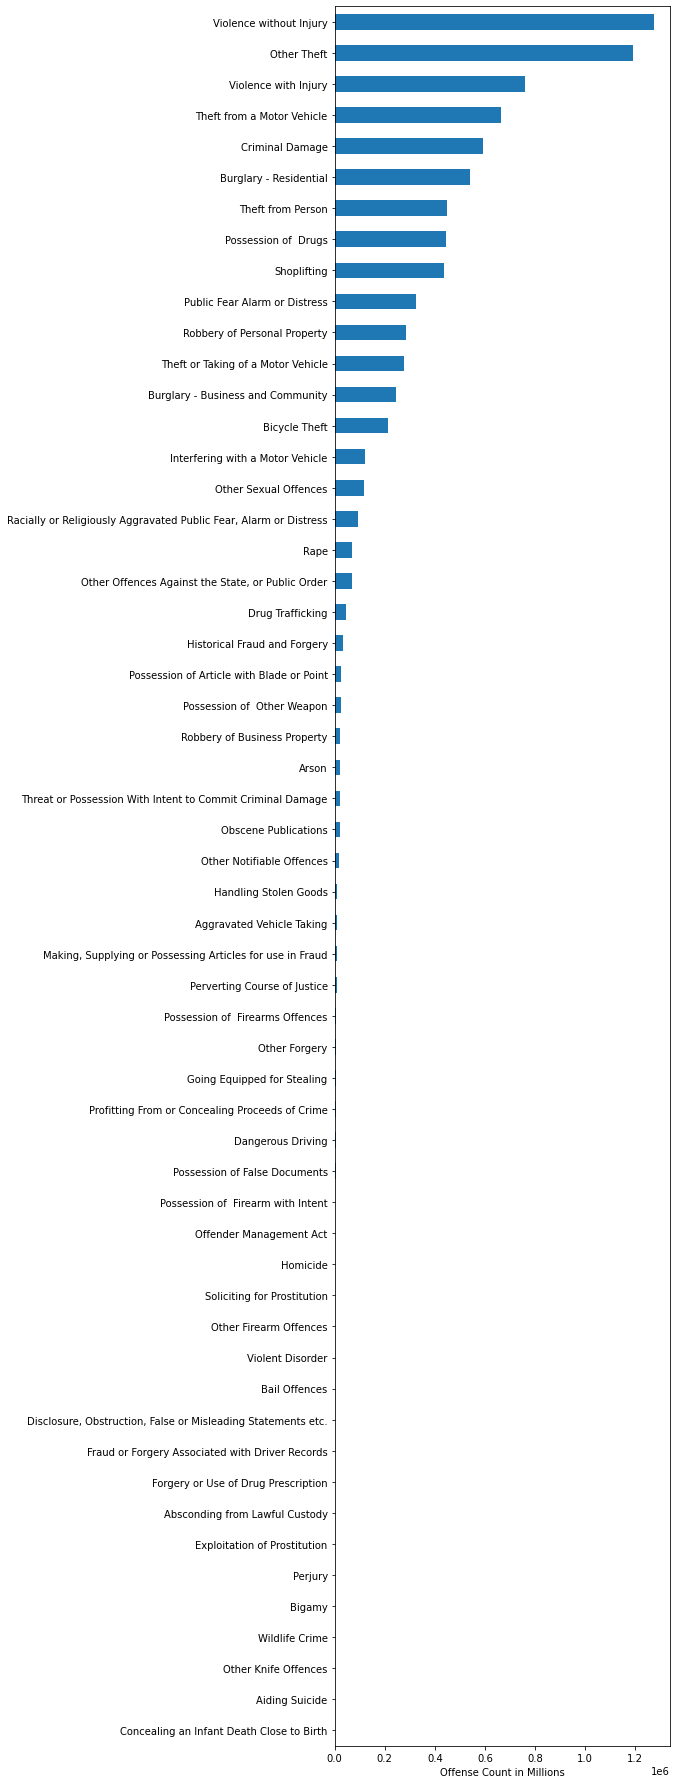

In [14]:
fix, ax = plt.subplots(figsize=(6,32))
df_offs_pivot_transpose.groupby(axis=1, level=2).sum().sum().sort_values().plot(kind='barh')
ax.set_ylabel('')
ax.set_xlabel('Offense Count in Millions')
plt.show();

In [15]:
import bar_chart_race as bcr

# Increase DPI a lot when downloading mp4 for report embedding

bcr.bar_chart_race(df=df_offs_pivot_transpose.groupby(level=0, axis=1).sum().cumsum(),
                   n_bars=10,
                   dpi=80,
                   filter_column_colors=True,
                   title='Total Recorded Offenses by Borough',
                   orientation='h')

/home/jamie/.pyenv/versions/lewagon/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/home/jamie/.pyenv/versions/lewagon/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [16]:
bcr.bar_chart_race(df=df_offs_pivot_transpose.groupby(level=0, axis=1).sum(),
                   n_bars=10,
                   title='Monthly Recorded Offenses by Borough')

/home/jamie/.pyenv/versions/lewagon/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/home/jamie/.pyenv/versions/lewagon/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/home/jamie/.pyenv/versions/lewagon/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


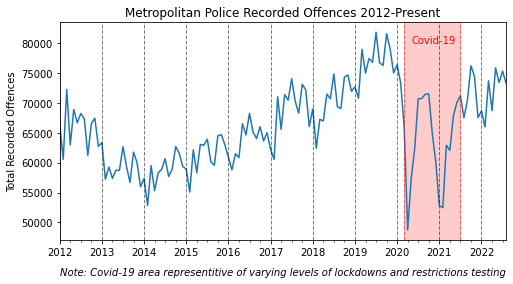

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

df_offs_pivot_transpose.sum(axis=1).plot()

for xc in ax.get_xticks():
    plt.axvline(x=xc, color='black', linestyle='--', lw=1, alpha=0.5 )
    
plt.axvline(x='03-2020', color='red', linestyle='--', lw=1, alpha=0.5 )
plt.axvline(x='07-2021', color='red', linestyle='--', lw=1, alpha=0.5 )    
    
ax.axvspan('03-2020', '07-2021', color='red', alpha=0.2)

ax.set_ylabel('Total Recorded Offences')
ax.set_title('Metropolitan Police Recorded Offences 2012-Present')   
ax.text('05-2020', 80000, 'Covid-19', color='red')

#ax.text('01-2012', 40000, 'Note: Covid-19 area representitive of varying levels of lockdowns and restrictions', fontstyle='italic')
ax.set_xlabel('Note: Covid-19 area representitive of varying levels of lockdowns and restrictions testing', loc='left', labelpad=10, fontstyle='italic')
plt.show();

In [18]:
def plot_trends(df: pd.DataFrame):

    fig = plt.figure(figsize=(18,5))

    gs = GridSpec(2, 2)
    gs.update(wspace=0.15, hspace=0.5)

    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])

    df.plot(ax=ax1)

    decompose_result = seasonal_decompose(df, model='multiplicative')

    # ax1.axvspan('03-2020', '07-2021', color='red', alpha=0.2)
    for xc in ax1.get_xticks():
        ax1.axvline(x=xc, color='black', linestyle='--', lw=1, alpha=0.5 )
        
    ax1.axvline(x='03-2020', color='red', linestyle='--', lw=1, alpha=0.5 )
    ax1.axvline(x='07-2021', color='red', linestyle='--', lw=1, alpha=0.5 ) 
    ax1.axvspan('03-2020', '07-2021', color='red', alpha=0.2)
    ax1.text('05-2020', ax1.get_yticks()[-2], 'Covid-19', color='red')

    ax1.set_ylabel('Total Recorded Offences')
    ax1.set_title('Monthly Recorded Offences 2012-Present')   
    # ax1.text('05-2020', 80000, 'Covid-19', color='red')
    ax1.set_xlabel('Note: Covid-19 area representitive of varying levels of lockdowns and restrictions', loc='left', labelpad=10, fontstyle='italic')

    decompose_result.trend.plot(ax=ax2)
    ax2.set_title('Trend')

    decompose_result.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality')

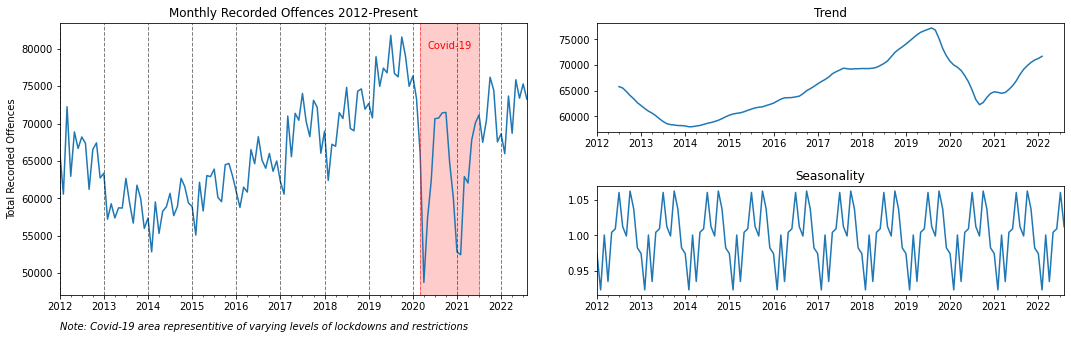

In [19]:
plot_trends(df_offs_pivot_transpose.sum(axis=1))

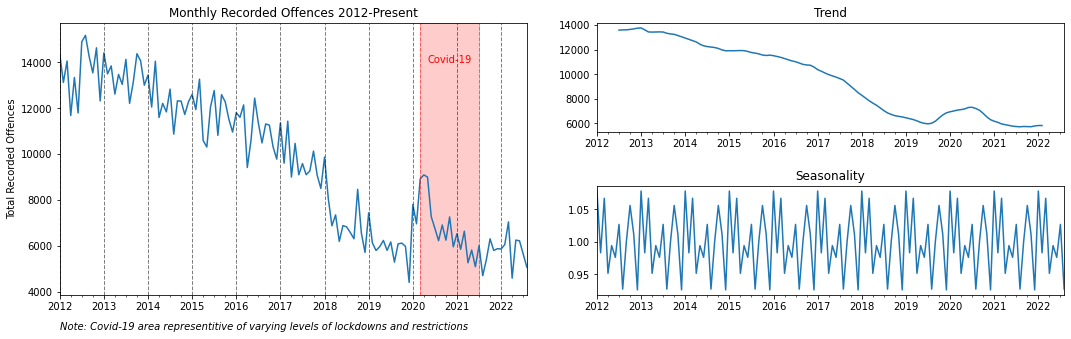

In [20]:
plot_trends(df_SDs_pivot_transpose.sum(axis=1))

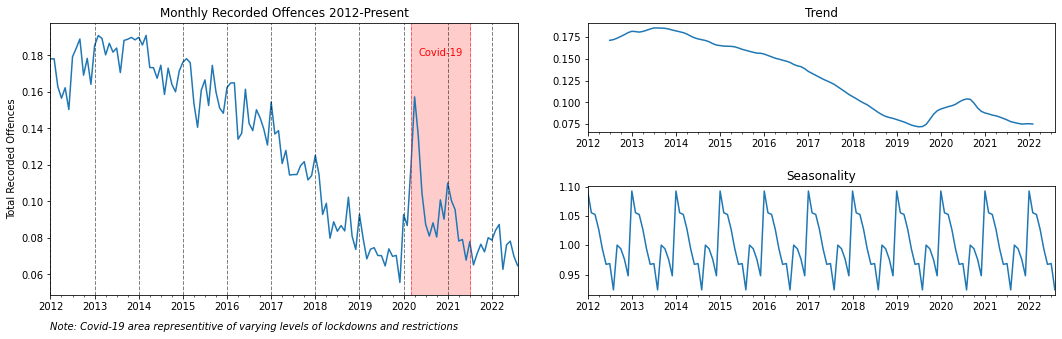

In [21]:
plot_trends(df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1)))

In [22]:
def minmax(series: pd.Series):
    '''Scales series to be in the range 0-1'''
    return (series - series.min()) / (series.max() - series.min())

In [23]:
((df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1))) - (df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1))).min()) / ((df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1))).max() - (df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1))).min())

2012-01-01    0.904663
2012-02-01    0.905111
2012-03-01    0.792801
2012-04-01    0.745564
2012-05-01    0.787883
                ...   
2022-04-01    0.053080
2022-05-01    0.152311
2022-06-01    0.167158
2022-07-01    0.105591
2022-08-01    0.068090
Length: 128, dtype: float64

In [24]:
trend_rate = seasonal_decompose(df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1)))
trend_detection = seasonal_decompose(df_SDs_pivot_transpose.sum(axis=1))
trend_offences = seasonal_decompose(df_offs_pivot_transpose.sum(axis=1))

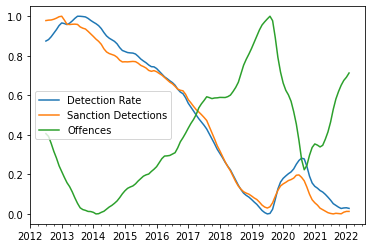

In [25]:
minmax(trend_rate.trend).plot(label='Detection Rate')
minmax(trend_detection.trend).plot(label='Sanction Detections')
minmax(trend_offences.trend).plot(label='Offences')
plt.legend()

<AxesSubplot:>

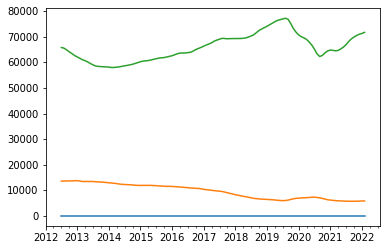

In [26]:
trend_rate.trend.plot(label='Detection Rate')
trend_detection.trend.plot(label='Sanction Detections')
trend_offences.trend.plot(label='Offences')

In [40]:
trend_rate.trend.max(), trend_rate.trend.argmax(), trend_rate.trend.min(), trend_rate.trend.argmin()

(0.18555529574851415, 18, 0.0720352959538252, 90)

In [52]:
(df_SDs_pivot_transpose.sum(axis=1) / (df_SDs_pivot_transpose.sum(axis=1) + df_offs_pivot_transpose.sum(axis=1)))[-1]

0.06478172070462088

In [63]:
(df_offs_pivot_transpose.loc['2022-08-01'] / df_offs_pivot_transpose.loc['2021-08-01']).sort_values(ascending=False)

Borough               MajorText                             MinorText                                      
Southwark             Miscellaneous Crimes Against Society  Fraud or Forgery Associated with Driver Records    inf
Sutton                Miscellaneous Crimes Against Society  Profitting From or Concealing Proceeds of Crime    inf
Richmond upon Thames  Violence Against the Person           Homicide                                           inf
Lewisham              Miscellaneous Crimes Against Society  Fraud or Forgery Associated with Driver Records    inf
Haringey              Possession of Weapons                 Possession of  Firearm with Intent                 inf
                                                                                                              ... 
Westminster           Miscellaneous Crimes Against Society  Soliciting for Prostitution                        NaN
                                                            Wildlife Crime             

In [71]:
df_offs_pivot_transpose.columns.get_level_values(0).unique()

Index(['Aviation Security(SO18)', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
       'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'Westminster'],
      dtype='object', name='Borough')

In [ ]:
pop_change_dict = {
    'Barking and Dagenham':1+0.162,
    'Barnet':1+0.178,
    'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
       'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'Westminster'
}

In [72]:
np.linspace(10,15,5)

array([10.  , 11.25, 12.5 , 13.75, 15.  ])